In [26]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 13

@author: yaning
"""

import pickle
import torch
import math
import matplotlib.pyplot as plt

In [ ]:
class Params:
    def __init__(self):
        self.u_se_ampa = 0.5
        self.u_se_nmda = 0.5
        self.u_se_gaba = 0.5
        self.tau_rec_ampa = 14.1
        self.tau_rec_nmda = 12.0
        self.tau_rec_gaba = 7.2
        self.tau_rise_ampa = 8.72
        self.tau_rise_nmda = 136.0
        self.tau_rise_gaba = 19.9
        self.learning_rate = 1.0
        self.weight_scale = 1.0

params = Params()

In [28]:

path = "/home/yaning/Documents/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(path + "fire_data_10p_8f_non_zero_background.pkl", "rb") as f:
    fire_data = pickle.load(f)

# for a quicker testing
fire_data = fire_data[...,:2000]

fire_data = torch.tensor(fire_data, device=device).float()


# parameters
gMax_Na = 120
rE_Na = 115

gMax_K = 36
rE_K = -12

gMax_leaky = 0.3
rE_leaky = 10.6

deltaTms = 0.05
Cm = 1
pointCount = fire_data.shape[-1]

# siemens unit n_s
min_current = 0
gMax_AMPA = 0.00072
gMax_NMDA = 0.0012
gMax_GABA = 0.0004
# gMax_GABA = 0.04

# # below are from the book
# gMax_AMPA = 0.72
# gMax_NMDA = 1.2
# gMax_GABA = 0.04

rE_AMPA = 70
rE_NMDA = 70
rE_GABA = 0

mg = 0.01
# mg = 1.2

threshold = -50 + 70
current_threshold = -200


# # guesses
# u_se = torch.tensor([0.9, 0.9, 0.9], device=device)
# tau_rec = torch.tensor([5, 12, 12], device=device)

# guesses
u_se = torch.tensor([params.u_se_ampa, params.u_se_nmda, params.u_se_gaba], device=device)
tau_rec = torch.tensor([params.tau_rec_ampa, params.tau_rec_nmda, params.tau_rec_gaba], device=device)

# below from paper 
tau_pre = torch.tensor([20, 20, 20], device=device)
tau_decay = torch.tensor([2.4, 100, 7], device=device)

# rise has to be quicker than decay, tau needs to be bigger (negative deri)
# tau_rise = torch.tensor([1, 50, 3], device=device)
tau_rise = torch.tensor([params.tau_rise_ampa, params.tau_rise_nmda, params.tau_rise_gaba], device=device)

# guesses
# learning_rate = 100
# weight_scale = 10

learning_rate = params.learning_rate
weight_scale = params.weight_scale


# generate the exponential decrease with time gap values
gaps = torch.arange(400, 0, -1, device=device).unsqueeze(0).expand(3,400)
temp_tau_pre = tau_pre.unsqueeze(-1)
weight_values_matrix = torch.exp(-gaps/temp_tau_pre)

for _ in range(5):
    weight_values_matrix = weight_values_matrix.unsqueeze(1)


def update_states(mp, current_states, deltaTms=0.05):
        m_alpha = .1*((25-mp) / (torch.exp((25-mp)/10)-1))
        m_beta = 4*torch.exp(-mp/18)
        n_alpha = .01 * ((10-mp) / (torch.exp((10-mp)/10)-1))
        n_beta = .125*torch.exp(-mp/80)
        h_alpha = .07*torch.exp(-mp/20)
        h_beta = 1/(torch.exp((30-mp)/10)+1)

        alphas = torch.stack([m_alpha, n_alpha, h_alpha], dim=0)
        betas = torch.stack([m_beta, n_beta, h_beta], dim=0)

        alpha_states = alphas*(1-current_states)
        beta_states = betas*current_states

        new_states = current_states + deltaTms*(alpha_states - beta_states)

        return new_states

def broadcast_params(param, target):
    # param = param[:,None]*torch.ones_like(target)[None,...]
    new_shape = (3,) + (1,)*(target.dim()-1)
    param = param.view(new_shape)
    param = param.expand_as(target)
    return param

def broadcast_mp(mp, connection_matrix):
    num_missing_dim = connection_matrix.dim() - mp.dim()
    mp = mp.view(*([1]*num_missing_dim), *mp.shape)
    mp = mp.expand_as(connection_matrix)
    return mp


def runge_kutta(f, y0, h, *arg):
    k1 = f(y0, *arg)
    k2 = f(y0 + h*k1/2, *arg)
    k3 = f(y0 + h*k2/2, *arg)
    k4 = f(y0 + h*k3, *arg)

    next = y0 + h/6*(k1 + 2*k2 + 2*k3 + k4)

    return next

# # deri as deriviation 
# def e_deri(e, on_off):
#     return (1-e)/tau_rec[None,:,None,None] - u_se[None,:,None,None]*on_off

# def g_decay_deri(g_decay, w, e, on_off):
#     return -g_decay/tau_decay[None,:,None,None] + w*e*on_off

# def g_rise_deri(g_rise, w, e, on_off):
#     return -g_rise/tau_rise[None,:,None,None] + w*e*on_off

# deri as deriviation 
def e_deri(e, on_off):
    tau_rec_broad = broadcast_params(tau_rec, e)
    u_se_broad = broadcast_params(u_se, e)
    return (1-e)/tau_rec_broad - u_se_broad*on_off*e

def g_decay_deri(g_decay, w, e, on_off):
    tau_decay_broad = broadcast_params(tau_decay, e)
    return -g_decay/tau_decay_broad + w*e*on_off

def g_rise_deri(g_rise, w, e, on_off):
    tau_rise_broad = broadcast_params(tau_rise, e)
    return -g_rise/tau_rise_broad + w*e*on_off

def update_gPs(es, ws, g_decays, g_rises, fires, recurrent, deltaTms=0.05):
    # cycle is how many layers it connects 
    cycle = len(es)
    new_es = []
    new_g_decays = []
    new_g_rises = []
    gPs = []
    
    for i in range(cycle):
        # print(es[i].shape)
        fire = fires[i]
        fire = fire.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        fire = fire.expand(*es[i].shape)

        if recurrent and i == 1:
            e = runge_kutta(e_deri, es[i], deltaTms, fire)
        else:
            e = es[i]
        if (e < 0).any():
            print("e negative")
            e[e < 0] = 0

        # update g_decay and g_rise
        # print(torch.isnan(ws[i]).any())
        # print(torch.isnan(e).any())
        # print(torch.isnan(fire).any())

        g_decay = runge_kutta(g_decay_deri, g_decays[i], deltaTms, ws[i], e, fire)
        g_rise = runge_kutta(g_rise_deri, g_rises[i], deltaTms, ws[i], e, fire)
        # print(torch.isnan(g_decay).any())
        # print(torch.isnan(g_rise).any())

        gP = g_rise - g_decay
        if (gP < 0).any():
            print("gP negative")
            gP[gP < 0] = 0
            
        new_es.append(e)
        new_g_decays.append(g_decay)
        new_g_rises.append(g_rise)
        gPs.append(gP)

    return new_es, new_g_decays, new_g_rises, gPs

# normalise per neuron only for the In --> E so don't need function
# def normalise_weight(ws, weight_scale=weight_scale):
#     # Accumulate mean and std without concatenating
#     total_sum_E = 0.0
#     total_count_E = 0.0
#     total_sum_I = 0.0
#     total_count_I = 0.0


#     for w in ws:
#         total_sum_E += w[0:2].sum()
#         total_count_E += w[0:2].numel()
#         total_sum_I += w[2].sum()
#         total_count_I += w[2].numel()


#     normalised_ws = []
    
#     for w in ws:
#         e = w[:2]/total_sum_E*total_count_E
#         i = w[2]/total_sum_I*total_count_I
#         i = i.unsqueeze(0)

#         # print(e.shape)
#         # print(i.shape)

#         whole = torch.cat((e,i), dim=0)*weight_scale
#         normalised_ws.append(whole)

#     return normalised_ws

# the last param is how many synapses it needs to have 
def initialise(*args):
    d = args[0]

    # cells, states, mp are fine with only individual cells
    cells = torch.zeros((d, d), device=device)

    m_states = cells.clone()
    m_states.fill_(0.061956531255774015)

    n_states = cells.clone()
    n_states.fill_(0.3384883478113268)

    h_states = cells.clone()
    h_states.fill_(0.5484107720738856)

    states = torch.stack([m_states, n_states, h_states], dim=0)

    mp = cells.clone()
    mp.fill_(1.3458754117369027)

    # the synapses properties are not individual cell but 
    # shape as the connections

    es = []
    ws = []
    g_decays = []
    g_rises = []

    for arg in args[1:]:
        gaussian = arg[1]
        arg = arg[0]
        muster = torch.zeros(arg.shape, device=device)

        e = muster.clone()
        e.fill_(1)
        es.append(e)

        #---------------------about weight---------------------------------------
        if not gaussian:
            w = torch.rand(*arg.shape[1:], device=device)*weight_scale
        else:
            w = torch.ones(*arg.shape[1:], device=device)*weight_scale
        shape = [3] + [1]*w.ndim
        # I think i can also use expand here but let's not get very confusing
        w = w.unsqueeze(0).repeat(shape)
        # w = torch.rand(*arg.shape, device=device)*weight_scale

        w = w*arg

        # print(w)

        ws.append(w)


        #-----------------------------------------------------------------------

        g_decay = muster.clone()
        g_decay.fill_(1)
        g_decay = g_decay*arg
        g_decays.append(g_decay)

        g_rise = muster.clone()
        g_rise.fill_(1)
        g_rise = g_rise*arg
        g_rises.append(g_rise)


    # normalise ws
    



    return cells, states, mp, es, ws, g_decays, g_rises

def check_fire(mp):
    activeness = (mp > threshold).float()
    return activeness


def update_I_E(mp, gPs, states):

    # generate currents based on gPs
    cycle = len(gPs)
    muster = torch.zeros_like(mp)

    AMPA_currents = muster.clone()
    NMDA_currents = muster.clone()
    GABA_currents = muster.clone()
    
    for i in range(cycle):
        temp_mp = broadcast_mp(mp, gPs[i])
        # print(gPs[i])

        AMPA_currents += (gMax_AMPA*gPs[i][0,...]*(temp_mp-rE_AMPA)).sum(dim=tuple(range(temp_mp.ndim - 2)))
        # if (temp_mp-rE_AMPA).all() > 0:
        #     print("nooo")
        NMDA_currents += (gMax_NMDA*gPs[i][1,...]*(1/1+mg*torch.exp(-0.062*temp_mp)/3.57)*(temp_mp-rE_NMDA)).sum(dim=tuple(range(temp_mp.ndim - 2)))
        GABA_currents += (gMax_GABA*gPs[i][2,...]*(temp_mp-rE_GABA)*(-1)).sum(dim=tuple(range(temp_mp.ndim - 2)))

    # print("begin")
    # print(torch.isnan(AMPA_currents).any())
    # print(torch.isnan(NMDA_currents).any())
    # print(torch.isnan(GABA_currents).any())
    # print("end")
    # print("ampa:", AMPA_currents)
    # print("nmda:", NMDA_currents)
    # print("gaba:", GABA_currents)


    Ireceptors = AMPA_currents + NMDA_currents + GABA_currents
    # if Ireceptors.min() < min_current:
    #     min_current = Ireceptors.min()

    Ireceptors[Ireceptors >= 0] = 0.0


    overflow_neurons = (Ireceptors <= current_threshold).float()

    
    sodium_currents = gMax_Na*torch.pow(states[0], 3) * states[2]*(mp-rE_Na)
    potassium_currents = gMax_K*torch.pow(states[1], 4)*(mp-rE_K)
    leaky_currents = gMax_leaky*(mp-rE_leaky)


    total_I = - sodium_currents - potassium_currents - leaky_currents - Ireceptors

    mp = mp + deltaTms*total_I/Cm
    # print(Ireceptors)
    # print(Ireceptors.shape)

    return mp


    # mp = mp + deltaTms*total_I/Cm

    # return mp, ws


# initialise everything

pixel_num = 10
feature_num = 8
E_num = 20
I_num = 4
Out_num = 5


#-----------connection matrices-------------
# ampa
In_con_E = torch.zeros(3, pixel_num, pixel_num, feature_num, E_num, E_num, device=device)
# all-to-all  connections
In_con_E[0].fill_(1.)


# ampa and nmda
E_con_E = torch.zeros(E_num, E_num, E_num, E_num, device=device)
sigma_E_E = 2
max_E_E = 10
for i in range(E_num):
    for j in range(E_num):
        for k in range(E_num):
            for l in range(E_num):
                project_center_x = k
                project_center_y = l

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_E[i,j,k,l] = max_E_E*math.exp(-0.5*(euc_distance/sigma_E_E)**2)
E_con_E = E_con_E.permute(2, 3, 0, 1)
E_con_E = E_con_E.unsqueeze(0).repeat(3,1,1,1,1)
E_con_E[-1] = 0


# E to I connection matrix (p=0.1)
# ampa and nmda 
E_con_I = torch.zeros(E_num, E_num, I_num, I_num, device=device)
num_elements = E_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
E_con_I.view(-1)[flat_indices] = 1
E_con_I = E_con_I.unsqueeze(0).repeat(3,1,1,1,1)
E_con_I[-1] = 0

# I to E connection matrix (p=0.024)
# gaba
I_con_E = torch.zeros(I_num, I_num, E_num, E_num, device=device)
num_elements = I_con_E.numel()
num_ones = max(1, int(num_elements * 0.024))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_E.view(-1)[flat_indices] = 1
I_con_E = I_con_E.unsqueeze(0).repeat(3,1,1,1,1)
I_con_E[0] = 0
I_con_E[1] = 0

# I to I self connection (p=0.1)
# gaba
I_con_I = torch.zeros(I_num, I_num, I_num, I_num, device=device)
num_elements = I_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_I.view(-1)[flat_indices] = 1
I_con_I = I_con_I.unsqueeze(0).repeat(3,1,1,1,1)
I_con_I[0] = 0
I_con_I[1] = 0

# E to Out connection
# ampa
E_con_Out = torch.zeros(E_num, E_num, Out_num, Out_num, device=device)
sigma_E_Out = 2
max_E_Out = 10
# find the center point from Output to E
ratio = E_num/Out_num
for i in range(E_num):
    for j in range(E_num):
        for k in range(Out_num):
            for l in range(Out_num):
                project_center_x = k*ratio
                project_center_y = l*ratio

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_Out[i,j,k,l] = max_E_Out*math.exp(-0.5*(euc_distance/sigma_E_Out)**2)
E_con_Out = E_con_Out.unsqueeze(0).repeat(3,1,1,1,1)
E_con_Out[1] = 0
E_con_Out[2] = 0


#----------E---------------------
E_cells, E_states, E_mp, E_es, E_ws, E_g_decays, E_g_rises = initialise(E_num, [In_con_E, False], [E_con_E, True], [I_con_E, False])
# E_ws = normalise_weight(E_ws)


#----------I-----------------
I_cells, I_states, I_mp, I_es, I_ws, I_g_decays, I_g_rises = initialise(I_num, [E_con_I, False], [I_con_I, False])
# I_ws = normalise_weight(I_ws)

#-----------Output-------------
Out_cells, Out_states, Out_mp, Out_es, Out_ws, Out_g_decays, Out_g_rises = initialise(Out_num, [E_con_Out, True])
# Out_ws = normalise_weight(Out_ws)

# -----------------------------------------run-------------------------------------------------
one_pic = fire_data[25,...]

dims = list(range(one_pic.ndim))
new_order = [dims[-1]] + dims[:-1]
In_fires = one_pic.permute(new_order)
E_fires = torch.zeros((pointCount, E_num, E_num), device=device)
I_fires = torch.zeros((pointCount, I_num, I_num), device=device)
Out_fires = torch.zeros((pointCount, Out_num, Out_num), device=device)


for t in range(pointCount):
    if t % 1000 == 0:  # every 50 steps
        print(f"Progress: {t}/{pointCount} ({100*t/pointCount:.1f}%)")
    # check mp and which fires then change connected layer activeness
    # Input to E
    In_fire = one_pic[:, :, :, t]
    # print(E_mp)
    # print(t)
    if E_mp.isnan().any():
        print("oops")
        print(t)
        data = {
            'In_fires': In_fires*100,
            'E_fires': E_fires,
            'I_fires': I_fires,
            'Out_fires': Out_fires
        }

        # with open(path + 'large_files/fires_new.pkl', 'wb') as f:
        #     pickle.dump(data, f)
        
        break

    E_fire = check_fire(E_mp)
    # E_fires[t] = E_fire
    E_fires[t] = E_mp

    # if t >= 500:
    #     print(torch.all(E_mp == E_mp[0]).item())


    I_fire = check_fire(I_mp)
    # I_fires[t] = I_fire
    I_fires[t] = I_mp
    
    
    Out_fire = check_fire(Out_mp)
    # Out_fires[t] = Out_fire
    Out_fires[t] = Out_mp


    # -----------------update gPs based on activeness--------------------------------
    # update them by each layer connection, cannot do it at the same time because
    # the shapes are different
    # E_states = runge_kutta(update_states, E_states, deltaTms, E_mp)
    E_states = update_states(E_mp, E_states)
    E_es, E_g_decays, E_g_rises, E_gPs = update_gPs(E_es, E_ws, E_g_decays, E_g_rises, [In_fire, E_fire, I_fire], 1)
    
    # # print(E_es)
    # print(torch.isnan(E_es[0]).any())
    # print(torch.isnan(E_es[1]).any())
    # print(torch.isnan(E_es[2]).any())

    # I_states = runge_kutta(update_states, I_states, deltaTms, I_mp)
    I_states = update_states(I_mp, I_states)
    I_es, I_g_decays, I_g_rises, I_gPs = update_gPs(I_es, I_ws, I_g_decays, I_g_rises, [E_fire, I_fire], 0)

    # Out_states = runge_kutta(update_states, Out_states, deltaTms, Out_mp)
    Out_states = update_states(Out_mp, Out_states)
    Out_es, Out_g_decays, Out_g_rises, Out_gPs = update_gPs(Out_es, Out_ws, Out_g_decays, Out_g_rises, [E_fire], 0)


    # print("E")
    # ------------------generate currents and voltages based on gPs-------------------------------
    E_mp = update_I_E(E_mp, E_gPs, E_states)
    # E_mp, E_ws = update_I_E(E_gPs, E_mp, E_states, E_ws)
    
    # print("I")
    I_mp = update_I_E(I_mp, I_gPs, I_states)
    # I_mp, I_ws = update_I_E(I_gPs, I_mp, I_states, I_ws)

    # print("Out")
    Out_mp = update_I_E(Out_mp, Out_gPs, Out_states)
    # Out_mp, Out_ws = update_I_E(Out_gPs, Out_mp, Out_states, Out_ws)

    
    # -------------------------update weights----------------------------------
    # only In to E
    # get the matrix of needed to change weight from the cons (Q: including the current time step?)
    # take only the 400 time step before, equals to 20ms, which is the learning period in the paper
    # for now update after 400 time steps 
    if t >= 400:
        past_pre_fires = In_fires[t-399:t+1,:,:,:]
        # using just multiplication
        interactions = torch.einsum('tijk,ab->ijkabt', past_pre_fires, E_fire)
        dw = (interactions*weight_values_matrix).sum(dim=-1)[0]
        E_ws[0][0] += dw*learning_rate
    # print(E_ws[0])
    # only normalise the In to E connection
    E_ws[0][0] = E_ws[0][0]/E_ws[0][0].sum(dim=(0,1,2), keepdim=True)




    # voltages.append(E_mp[10,10].cpu()-70)

data = {
    'In_fires': In_fires*100,
    'E_fires': E_fires,
    'I_fires': I_fires,
    'Out_fires': Out_fires
}

# with open(path + 'large_files/fires_new.pkl', 'wb') as f:
#     pickle.dump(data, f)



Progress: 0/2000 (0.0%)
Progress: 1000/2000 (50.0%)


In [ ]:
# the last param is how many synapses it needs to have 
def initialise(*args):
    d = args[0]

    # cells, states, mp are fine with only individual cells
    cells = torch.zeros((d, d), device=device)

    m_states = cells.clone()
    m_states.fill_(0.061956531255774015)

    n_states = cells.clone()
    n_states.fill_(0.3384883478113268)

    h_states = cells.clone()
    h_states.fill_(0.5484107720738856)

    states = torch.stack([m_states, n_states, h_states], dim=0)

    mp = cells.clone()
    mp.fill_(1.3458754117369027)

    # the synapses properties are not individual cell but 
    # shape as the connections

    es = []
    ws = []
    g_decays = []
    g_rises = []

    for arg in args[1:]:
        muster = torch.zeros(arg.shape, device=device)

        e = muster.clone()
        e.fill_(1)
        es.append(e)

        #---------------------about weight---------------------------------------
        # w = torch.rand(*arg.shape[1:], device=device)*weight_scale
        w = torch.ones(*arg.shape[1:], device=device)*weight_scale
        shape = [3] + [1]*w.ndim
        # I think i can also use expand here but let's not get very confusing
        w = w.unsqueeze(0).repeat(shape)
        # w = torch.rand(*arg.shape, device=device)*weight_scale

        w = w*arg

        # print(w)

        ws.append(w)


        #-----------------------------------------------------------------------

        g_decay = muster.clone()
        g_decay.fill_(1)
        g_decay = g_decay*arg
        g_decays.append(g_decay)

        g_rise = muster.clone()
        g_rise.fill_(1)
        g_rise = g_rise*arg
        g_rises.append(g_rise)


    # normalise ws
    



    return cells, states, mp, es, ws, g_decays, g_rises


In [32]:
E_cells, E_states, E_mp, E_es, E_ws, E_g_decays, E_g_rises = initialise(E_num, [In_con_E, False], [E_con_E, True], [I_con_E, False])

In [35]:
E_ws[0].shape

torch.Size([3, 10, 10, 8, 20, 20])

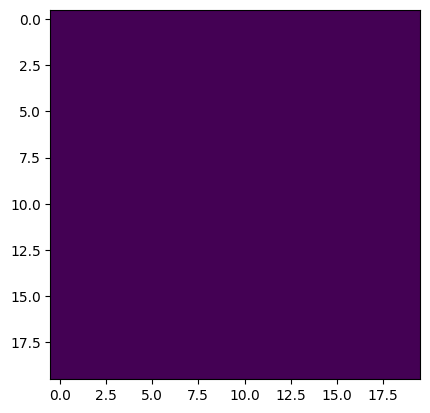

In [41]:
plt.imshow(E_ws[0][1, 5, 5, 4].cpu().numpy(), cmap="viridis", interpolation="nearest")

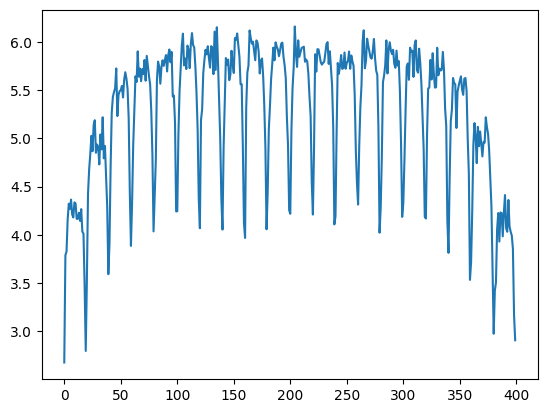

In [ ]:
plt.plot(E_mp.view(-1).cpu().numpy())

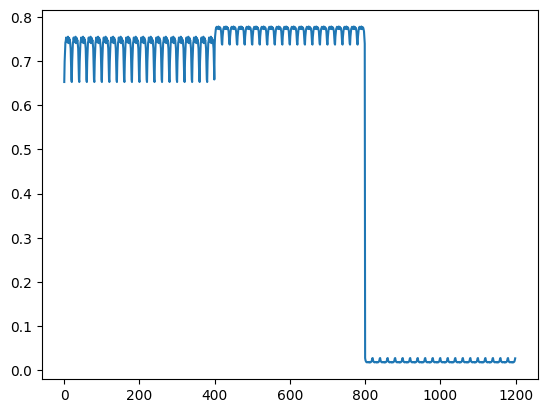

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(E_states.view(-1).cpu().numpy())


In [ ]:
torch.isnan(E_es[0][1]).any()

tensor(False, device='cuda:0')